### **1. Generate the Data Matrix and the Label vector**


In [ ]:
## Convert images in subfolders
import os
import cv2
import numpy as np

image_folder_path = '/content/drive/MyDrive/FaceReco'
image_size = (92, 112)  # Size of each image

# Initialize the matrix
matrix = np.zeros((400, image_size[0] * image_size[1]), dtype=np.uint8)
y = np.zeros((400,), dtype=np.uint8)

person_count = 0
for person_folder in sorted(os.listdir(image_folder_path)):
    person_folder_path = os.path.join(image_folder_path, person_folder)
    if os.path.isdir(person_folder_path):
        for i, image_file in enumerate(sorted(os.listdir(person_folder_path))):
            image_path = os.path.join(person_folder_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            resized_image = cv2.resize(image, image_size)
            matrix[person_count * 10 + i, :] = resized_image.flatten()
            y[person_count * 10 + i] = person_count + 1


        person_count += 1

print("Matrix shape: ", matrix.shape)
print("Number of persons: ",person_count)
print("Y shape: " , y.shape)


# The code loops through each person's subfolder, reads each image,
# resizes it to the desired dimensions (92 x 112), and flattens it into a 1D array.
# The flattened array is then stored as a row in the matrix. The resulting matrix will have dimensions 400 x (92 x 112), where each row represents an image.




Matrix shape:  (400, 10304)
Number of persons:  40
Y shape:  (400,)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

### **2. Split the Dataset into Training and Test sets**



In [ ]:
X_train = matrix[::2]  # Selecting the odd rows for training
X_test = matrix[1::2]  # Selecting the even rows for testing

# Splitting the labels vector
y_train = y[::2]
y_test = y[1::2]

# Printing the shapes of the resulting datasets
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (200, 10304)
Testing data shape: (200, 10304)
Training labels shape: (200,)
Testing labels shape: (200,)


### **3.Classification using PCA**

In [ ]:
## Step 1 get the mean vector
mean_vector = np.mean(X_train, axis=0)
mean_vector.shape

(10304,)

In [ ]:
## Step 2 center the points around (0,0)
centered_X_train = X_train - mean_vector


In [ ]:
## Step 3 compute covariance matrix
covariance_matrix = np.cov(centered_X_train.T,bias=True)


In [ ]:
## Step 4
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
eigenvalues

array([ 2.86568294e+06+0.00000000e+00j,  2.04715188e+06+0.00000000e+00j,
        1.12244083e+06+0.00000000e+00j, ...,
       -3.95706238e-13-1.52430174e-13j, -2.10296165e-13+0.00000000e+00j,
       -5.05237950e-13+0.00000000e+00j])

In [ ]:
print(len(eigenvalues))
print(max(eigenvalues))
print(min(eigenvalues))

10304
(2865682.9403091064+0j)
(-1.4685814900304072e-10+0j)


In [ ]:
eigenvectors.shape

(10304, 10304)

In [ ]:
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]
sorted_eigenvalues

array([ 2.86568294e+06+0.j,  2.04715188e+06+0.j,  1.12244083e+06+0.j, ...,
       -7.26779361e-11+0.j, -8.46411803e-11+0.j, -1.46858149e-10+0.j])

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


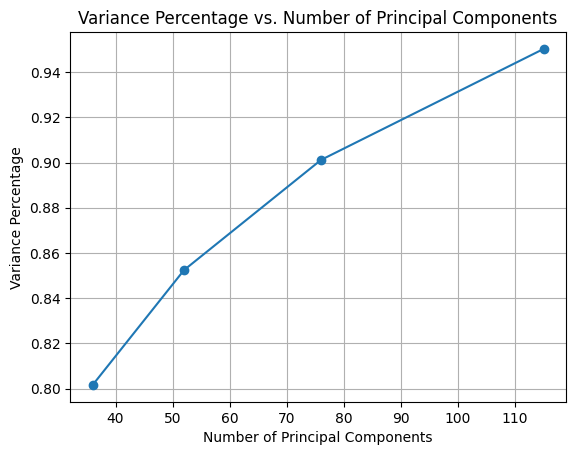

[36, 52, 76, 115]

In [ ]:
import matplotlib.pyplot as plt

total_sum = np.sum(sorted_eigenvalues)
desired_variance_percentages = [0.8, 0.85, 0.9, 0.95]
num_components = []
variance_ratios = []

for desired_variance_percentage in desired_variance_percentages:
    cumulative_sum = 0.0
    num_pca = 0

    for eigenvalue in sorted_eigenvalues:
        cumulative_sum += eigenvalue
        num_pca += 1
        variance_ratio = cumulative_sum / total_sum

        if variance_ratio >= desired_variance_percentage:
            break

    num_components.append(num_pca)
    variance_ratios.append(variance_ratio)

plt.plot(num_components, variance_ratios, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Percentage')
plt.title('Variance Percentage vs. Number of Principal Components')
plt.grid(True)
plt.show();
num_components

In [ ]:
mymap = {}
i = 0
for var in desired_variance_percentages :
  mymap[var] = num_components[i]
  i+=1
mymap

{0.8: 36, 0.85: 52, 0.9: 76, 0.95: 115}

In [ ]:
## Selecting the top eigen_vectors for the projection matrix
centered_X_train = X_train - mean_vector
centered_X_test = X_test - mean_vector
X_train_projected_matrix = []
X_test_projected_matrix = []
for key,value in mymap.items() :
  print(key)
  U = sorted_eigenvectors[:, :mymap[key]]
  print(U.shape)
  X_train_projected = np.dot(centered_X_train, U)
  X_test_projected = np.dot(centered_X_test, U)
  X_train_projected_matrix.append(X_train_projected)
  X_test_projected_matrix.append(X_test_projected)


0.8
(10304, 36)
0.85
(10304, 52)
0.9
(10304, 76)
0.95
(10304, 115)


### **4.Using Simple Classifier**

In [ ]:
## Use a simple qualifier
from sklearn.neighbors import KNeighborsClassifier

# Define the number of neighbors for the KNN classifier
n_neighbors = [1,3,5,7]

# Perform classification for each alpha
accuracies = []
for i in range(4) :a
  print("For Chosen percentage of features:",desired_variance_percentages[i])
  for neighbor in n_neighbors:
    print("Shape of the Matrix: ",X_train_projected_matrix[i].shape)
    X_train_real = np.real(X_train_projected_matrix[i])
    X_test_real= np.real(X_test_projected_matrix[i])
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train_real, y_train)
    print("Accuracy:", knn.score(X_test_real, y_test))

For Chosen percentage of features: 0.8
Shape of the Matrix:  (200, 36)
Accuracy: 0.94
Shape of the Matrix:  (200, 36)
Accuracy: 0.875
Shape of the Matrix:  (200, 36)
Accuracy: 0.825
Shape of the Matrix:  (200, 36)
Accuracy: 0.775
For Chosen percentage of features: 0.85
Shape of the Matrix:  (200, 52)
Accuracy: 0.94
Shape of the Matrix:  (200, 52)
Accuracy: 0.87
Shape of the Matrix:  (200, 52)
Accuracy: 0.825
Shape of the Matrix:  (200, 52)
Accuracy: 0.755
For Chosen percentage of features: 0.9
Shape of the Matrix:  (200, 76)
Accuracy: 0.94
Shape of the Matrix:  (200, 76)
Accuracy: 0.875
Shape of the Matrix:  (200, 76)
Accuracy: 0.81
Shape of the Matrix:  (200, 76)
Accuracy: 0.74
For Chosen percentage of features: 0.95
Shape of the Matrix:  (200, 115)
Accuracy: 0.93
Shape of the Matrix:  (200, 115)
Accuracy: 0.865
Shape of the Matrix:  (200, 115)
Accuracy: 0.79
Shape of the Matrix:  (200, 115)
Accuracy: 0.715
